In [8]:
import sys
from pathlib import Path

In [9]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports

In [10]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [11]:
import yolov1
from yolov1.config import parse_config

In [12]:
from yolov1.data.dataset import YOLODataset
from yolov1.utils.vis import draw_boxes_pil, draw_boxes_tensor
from yolov1.utils.general import decode_labels

## config

In [13]:
config_path = "../yolov1/src/yolov1/configs/default.yaml"

In [14]:
config = parse_config(config_file=config_path)

config.dict()

{'data': {'root': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data',
  'train': 'valid',
  'val': 'valid',
  'names': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'],
  'augmentations': {'horizontal_flip': 0.8,
   'vertical_flip': 0.0,
   'brightness_contrast': 0.8,
   'shift_scale_rotate': 0.0,
   'random_crop': 0.8,
   'random_crop_dims': (224.0, 224.0)}},
 'training': {'epochs': 100,
  'dls_kwargs': {'pin_memory': True,
   'batch_size': 32,
   'drop_last': True,
   'num_workers': 2},
  'optim_kwargs': {'lr': 0.001, 'weight_decay': 0.0001},
  'checkpoints_dir': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints',
  'save_freq': 20,
  'loss': {'l_coord': 5.0, 'l_obj': 1.5, 'l_noobj': 0.5, 'l_class': 1.0}},
 'inference': {'checkpoint': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints/final_epoch_50.pt',
  'source': '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data/valid/images',
  'dls_kwargs': {'pin_me

## dataset

In [8]:
train_ds = YOLODataset(config, mode="train")

2024-05-09T04:38:31.210123Z [info     ] Loaded 250 samples             func_name=get_data lineno=68


In [9]:
len(train_ds[2])

2

In [12]:
sample = train_ds[4]

In [15]:
sample[0].shape

torch.Size([3, 224, 224])

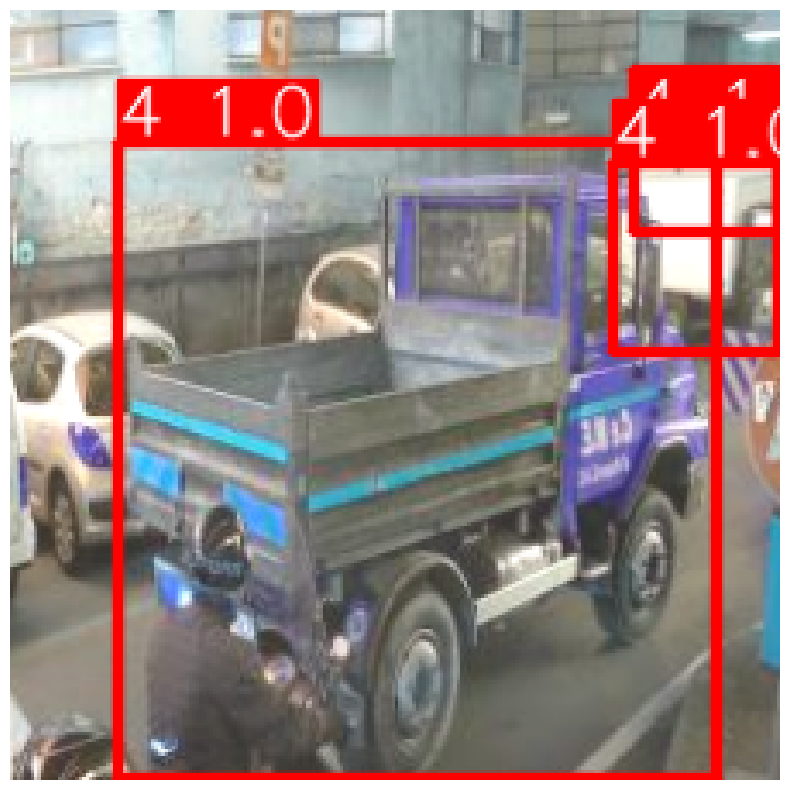

In [16]:
draw_boxes_tensor(
    sample[0],
    decode_labels(sample[1], config.model.S, config.model.B, config.model.nc))

In [17]:
val_ds = YOLODataset(config, mode="val")

2024-05-07T07:27:37.219178Z [info     ] Loaded 250 samples             func_name=get_data lineno=68


## dataloader

In [124]:
train_dataloader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=config.training.batch_size,
        shuffle=True,
        num_workers=config.training.num_workers,
    )
# val_dataloader = torch.utils.data.DataLoader(
#     val_ds,
#     batch_size=config.training.batch_size,
#     shuffle=False,
#     num_workers=config.training.num_workers
# )

Reloading 'yolov1.data.dataset'.


## arch

In [14]:
# from yolov1.models.arch import YOLOv1

In [15]:
# model = YOLOv1(config.model)

## train

In [15]:
from yolov1.train import main

In [ ]:
main(config)

Reloading 'yolov1.models.arch'.
2024-05-09T12:50:40.975398Z [info     ] Loaded 250 samples             func_name=get_data lineno=68
Loading pretrained weights from Hugging Face hub (timm/resnet34.a1_in1k)
[timm/resnet34.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-05-09T12:50:41.881174Z [info     ] Loaded model successfully with 1302506 trainable params func_name=main lineno=63


/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


2024-05-09T12:50:48.639712Z [info     ] Epoch [1/100], Train Loss: {'total': 328.4780491420201, 'coord': 78.29305158342633, 'obj': 14.756185259137835, 'noobj': 203.28511701311385, 'class': 32.14369446890695} func_name=main lineno=76
2024-05-09T12:50:54.435742Z [info     ] Epoch [2/100], Train Loss: {'total': 313.8539472307478, 'coord': 72.66383470807757, 'obj': 13.121270997183663, 'noobj': 197.85763331821985, 'class': 30.211211340767996} func_name=main lineno=76
2024-05-09T12:50:59.764720Z [info     ] Epoch [3/100], Train Loss: {'total': 304.0848824637277, 'coord': 68.56222643171039, 'obj': 12.231340544564384, 'noobj': 193.7356458391462, 'class': 29.555659430367605} func_name=main lineno=76
2024-05-09T12:51:05.164371Z [info     ] Epoch [4/100], Train Loss: {'total': 288.5466875348772, 'coord': 59.48326982770647, 'obj': 12.890116555350167, 'noobj': 188.77833557128906, 'class': 27.394957951137} func_name=main lineno=76
2024-05-09T12:51:10.580894Z [info     ] Epoch [5/100], Train Loss: {'

## infer

In [10]:
from yolov1.detect import main as detect_main
from yolov1.data.dataset import InferenceDataset
from yolov1.data.utils import get_dls_for_inference

In [30]:
config.inference.source = '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data/test/images'

In [11]:
config.inference.checkpoint = '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints/final_epoch_100.pt'

In [23]:
config.inference.conf_th = 0.3

In [30]:
for idx, res in enumerate(detect_main(config)):
    if idx == 1:
        break

Loading pretrained weights from Hugging Face hub (timm/resnet34.a1_in1k)
[timm/resnet34.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-05-09T07:23:25.592987Z [info     ] Model loaded successfully      func_name=main lineno=64


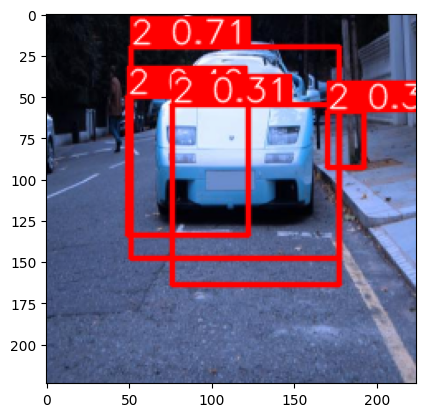

In [34]:
plt.imshow(res["drawn"][3])